In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.cluster import KMeans
import numpy as np

In [75]:
df = pd.read_csv("./data/Bold_744H-10_31-11_07.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,NaN,26.70198
3,10/31/2024 12:46:00 am,382.73955,NaN,NaN
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


In [5]:
df.shape

(677, 4)

In [88]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [7]:
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,375.0,27.17612
2,10/31/2024 12:30:00 am,380.72775,375.0,26.70198
3,10/31/2024 12:46:00 am,382.73955,375.0,26.70198
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Time                                677 non-null    object 
 1   Inj Gas Meter Volume Instantaneous  677 non-null    float64
 2   Inj Gas Meter Volume Setpoint       677 non-null    float64
 3   Inj Gas Valve Percent Open          677 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.3+ KB


In [9]:
df.describe()

,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
count,677.000000,677.0,677.000000
mean,356.988340,375.0,34.632537
std,70.040464,0.0,17.807582
min,0.000000,375.0,0.000000
25%,357.794850,375.0,27.478060
50%,374.232300,375.0,28.933010
75%,386.814450,375.0,32.676490
max,405.571950,375.0,100.000000


In [10]:
df.groupby(df["Inj Gas Meter Volume Setpoint"]).agg({"Inj Gas Valve Percent Open": ["mean"]})

,Inj Gas Valve Percent Open
,mean
Inj Gas Meter Volume Setpoint,
375.0,34.632537


In [89]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [12]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

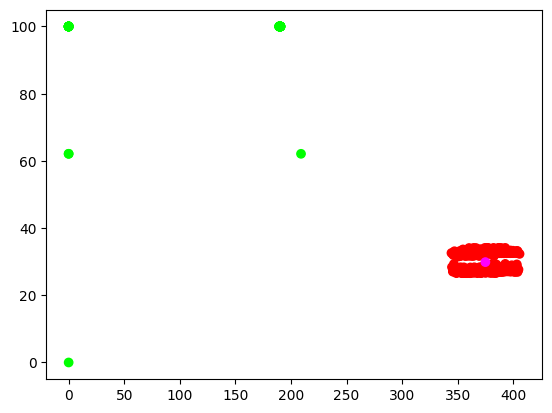

In [13]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")

plt.scatter(X, y, c=colors)

In [14]:
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

total = 0
count = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
    if pred == 0:
        total += distance
        count += 1
threshold = total / count
threshold *= 2

print(threshold)
error_threshold = 4 * threshold

28.73985298465573


In [15]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0
    else:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#00FF00")

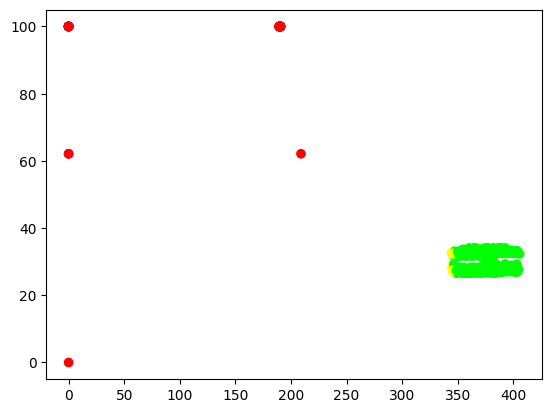

In [16]:
plt.scatter(X_concern, y_concern, c=colors)

In [17]:
warnings = df[(df["Issue"] == 2) | (df["Issue"] == 1)]
for i in range(0, df.shape[0]):
    print(f"{df.iloc[i,0]} ----- {df.iloc[i, 1]} ------  {df.iloc[i, 3]} ----- {df.iloc[i, 4]}")

10/31/2024 12:00:00 am ----- 391.4352 ------  27.17612 ----- 0
10/31/2024 12:14:00 am ----- 402.52365 ------  27.17612 ----- 0
10/31/2024 12:30:00 am ----- 380.72775 ------  26.70198 ----- 0
10/31/2024 12:46:00 am ----- 382.73955 ------  26.70198 ----- 0
10/31/2024 1:00:00 am ----- 384.86595 ------  26.70198 ----- 0
10/31/2024 1:14:00 am ----- 384.27975 ------  26.70198 ----- 0
10/31/2024 1:28:00 am ----- 383.2236 ------  26.70198 ----- 0
10/31/2024 1:44:00 am ----- 378.5196 ------  26.70198 ----- 0
10/31/2024 2:00:00 am ----- 374.74245 ------  26.70198 ----- 0
10/31/2024 2:14:00 am ----- 370.43145 ------  26.70198 ----- 0
10/31/2024 2:30:00 am ----- 364.6467 ------  26.70198 ----- 0
10/31/2024 2:46:00 am ----- 356.7471 ------  26.70198 ----- 0
10/31/2024 2:58:00 am ----- 348.91725 ------  26.77205 ----- 0
10/31/2024 3:14:00 am ----- 351.435 ------  31.71132 ----- 0
10/31/2024 3:28:00 am ----- 367.9839 ------  31.93819 ----- 0
10/31/2024 3:44:00 am ----- 360.4317 ------  31.93819 -----

In [18]:
df = pd.read_csv("./data/Courageous_729H-09_25-09_28.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,09/25/2024 12:00:00 am,993.002150,NaN,43.640763
1,09/25/2024 12:02:00 am,979.919175,NaN,43.473800
2,09/25/2024 12:04:00 am,976.157250,NaN,NaN
3,09/25/2024 12:06:00 am,963.743400,973.5,43.473800
4,09/25/2024 12:08:00 am,945.198300,NaN,44.332660


In [19]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [20]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [21]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

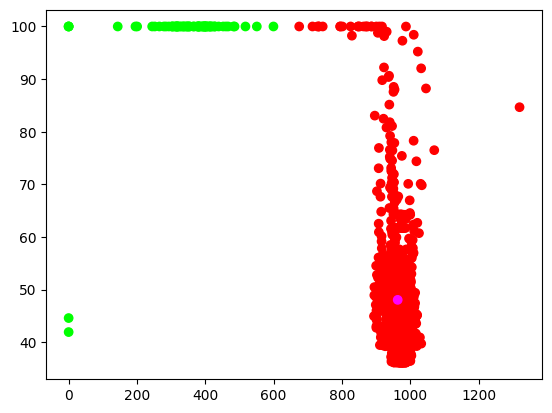

In [22]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [23]:
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

total = 0
count = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
    if pred == 0:
        total += distance
        count += 1
threshold = total / count
threshold *= 2

print(threshold)
error_threshold = 4 * threshold

46.501007812141765


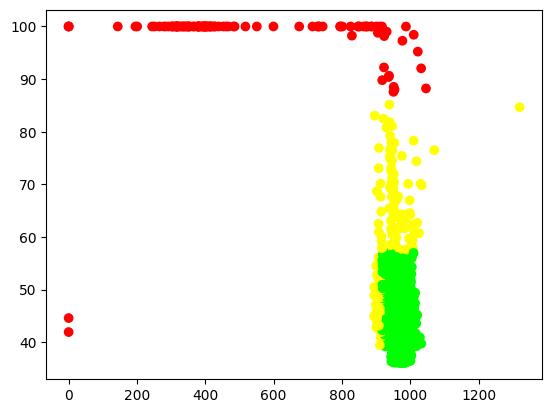

In [24]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0
    else:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#00FF00")

plt.scatter(X_concern, y_concern, c=colors)

In [25]:
warnings = df[(df["Issue"] == 2) | (df["Issue"] == 1)]
for i in range(0, df.shape[0]):
    print(f"{df.iloc[i,0]} ----- {df.iloc[i, 1]} ------  {df.iloc[i, 3]} ----- {df.iloc[i, 4]}")

09/25/2024 12:00:00 am ----- 993.0021499999996 ------  43.6407633333333 ----- 0
09/25/2024 12:02:00 am ----- 979.919175 ------  43.4738 ----- 0
09/25/2024 12:04:00 am ----- 976.15725 ------  43.4738 ----- 0
09/25/2024 12:06:00 am ----- 963.7434 ------  43.4738 ----- 0
09/25/2024 12:08:00 am ----- 945.1983 ------  44.33266 ----- 0
09/25/2024 12:12:00 am ----- 939.544575 ------  49.359535 ----- 0
09/25/2024 12:14:00 am ----- 965.904225 ------  51.36454 ----- 0
09/25/2024 12:16:00 am ----- 971.64525 ------  51.36454 ----- 0
09/25/2024 12:18:00 am ----- 968.4021 ------  51.36454 ----- 0
09/25/2024 12:20:00 am ----- 971.53935 ------  51.36454 ----- 0
09/25/2024 12:22:00 am ----- 982.63965 ------  51.36454 ----- 0
09/25/2024 12:24:00 am ----- 984.27795 ------  51.36454 ----- 0
09/25/2024 12:26:00 am ----- 990.134025 ------  51.36454 ----- 0
09/25/2024 12:28:00 am ----- 989.2005 ------  51.36454 ----- 0
09/25/2024 12:30:00 am ----- 985.114575 ------  51.36454 ----- 0
09/25/2024 12:32:00 am --

In [26]:
top = 0
bot = 0
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        if point[1] > center_y:
            top += 1
        else:
            bot += 1

print(top)
print(bot)

955
1065


In [27]:
highest = 0
lowest = 100

cluster_X = []
cluster_y = []
cluster_dataset = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        cluster_dataset.append(point)
        cluster_X.append(point[0])
        cluster_y.append(point[1])
        if point[1] > highest:
           highest = point[1]
        if point[1] < lowest:
           lowest = point[1]

distance = highest - lowest
distance

63.8592

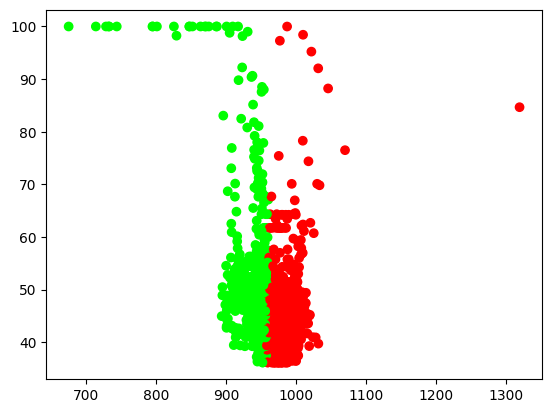

In [28]:
if distance > 30:
    colors = []
    mid = sum(cluster_X) / len(cluster_X)
    kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto", init=[[mid, 0], [mid, 100]]).fit(cluster_dataset)
    for i in range(0, len(cluster_X)):
        point = [cluster_X[i], cluster_y[i]]
        pred = kmeans.predict([point]).item()
        if pred == 0:
            colors.append("#FF0000")
        else:
            colors.append("#00FF00")
    
    plt.scatter(cluster_X, cluster_y, c=colors)

In [29]:
df = pd.read_csv("./data/Fearless_709H-10_31-11_07.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,559.02255,543.0,44.65046
1,10/31/2024 12:14:00 am,549.63090,NaN,44.68318
2,10/31/2024 12:30:00 am,586.35675,NaN,44.58979
3,10/31/2024 12:46:00 am,573.30135,NaN,44.62712
4,10/31/2024 1:00:00 am,564.64830,543.0,44.64499


In [30]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [31]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [32]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

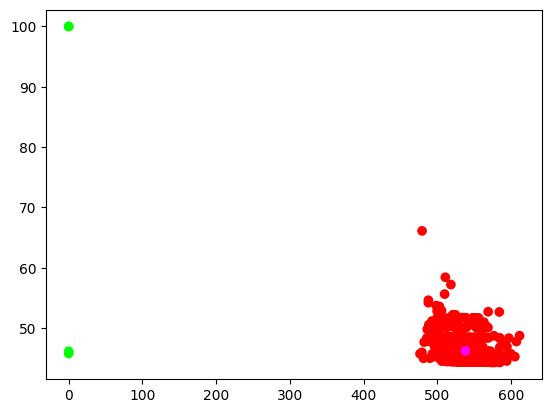

In [33]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [34]:
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

total = 0
count = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
    if pred == 0:
        total += distance
        count += 1
threshold = total / count
threshold *= 2

print(threshold)
error_threshold = 4 * threshold

39.52130845886338


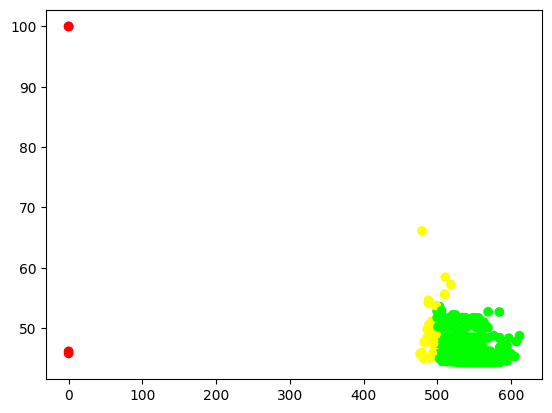

In [35]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0
    else:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#00FF00")

plt.scatter(X_concern, y_concern, c=colors)

In [36]:
warnings = df[(df["Issue"] == 2) | (df["Issue"] == 1)]
for i in range(0, df.shape[0]):
    print(f"{df.iloc[i,0]} ----- {df.iloc[i, 1]} ------  {df.iloc[i, 3]} ----- {df.iloc[i, 4]}")

10/31/2024 12:00:00 am ----- 559.0225499999999 ------  44.65046 ----- 0
10/31/2024 12:14:00 am ----- 549.6309 ------  44.68318 ----- 0
10/31/2024 12:30:00 am ----- 586.3567499999999 ------  44.58979 ----- 0
10/31/2024 12:46:00 am ----- 573.30135 ------  44.62712 ----- 0
10/31/2024 1:00:00 am ----- 564.6483000000001 ------  44.64499 ----- 0
10/31/2024 1:14:00 am ----- 559.5771 ------  44.65577 ----- 0
10/31/2024 1:28:00 am ----- 594.0436500000001 ------  44.5543 ----- 0
10/31/2024 1:44:00 am ----- 579.2346 ------  44.60474 ----- 0
10/31/2024 2:00:00 am ----- 575.6688 ------  44.612 ----- 0
10/31/2024 2:14:00 am ----- 569.6556 ------  44.63334 ----- 0
10/31/2024 2:30:00 am ----- 556.50495 ------  44.65831 ----- 0
10/31/2024 2:46:00 am ----- 582.01815 ------  44.58346 ----- 0
10/31/2024 3:00:00 am ----- 583.23225 ------  44.59333 ----- 0
10/31/2024 3:16:00 am ----- 557.40765 ------  44.62994 ----- 0
10/31/2024 3:28:00 am ----- 559.6974 ------  44.65321 ----- 0
10/31/2024 3:44:00 am ----- 

In [37]:
df = pd.read_csv("./data/Gallant_102H-10_04-10_11.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/04/2024 12:02:00 am,769.617750,NaN,43.854185
1,10/04/2024 12:04:00 am,770.582650,NaN,43.850995
2,10/04/2024 12:06:00 am,771.192900,750.0,43.850595
3,10/04/2024 12:08:00 am,771.011100,NaN,43.850210
4,10/04/2024 12:10:00 am,771.673725,NaN,43.847920


In [38]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [39]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [40]:
kmeans = kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

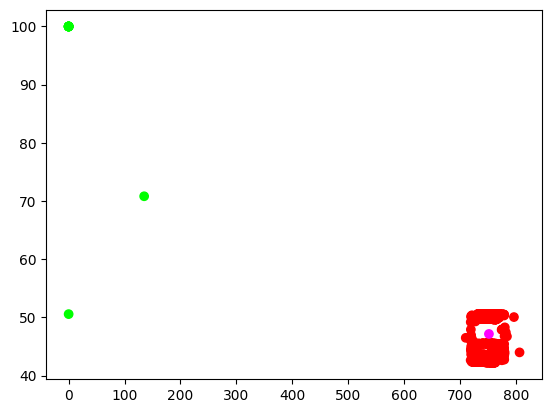

In [41]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [42]:
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

total = 0
count = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
    if pred == 0:
        total += distance
        count += 1
threshold = total / count
threshold *= 2

print(threshold)
error_threshold = 4 * threshold

25.64991967624438


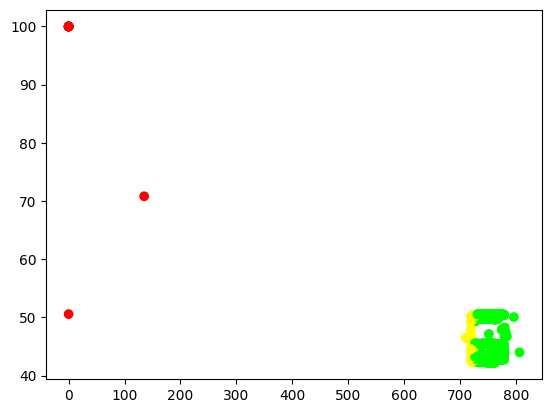

In [43]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0
    else:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#00FF00")

plt.scatter(X_concern, y_concern, c=colors)

In [44]:
df = pd.read_csv("./data/Noble_4H-10_24-10_29.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/24/2024 12:02:00 am,1194.800625,NaN,36.861895
1,10/24/2024 12:04:00 am,1199.565300,NaN,37.902420
2,10/24/2024 12:06:00 am,NaN,1200.0,NaN
3,10/24/2024 12:08:00 am,1193.520600,NaN,39.708210
4,10/24/2024 12:10:00 am,1204.110750,NaN,38.294660


In [45]:
old_setpoint = df.iloc[0, 2]
old_percent_open = df.iloc[0, 3]

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [46]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

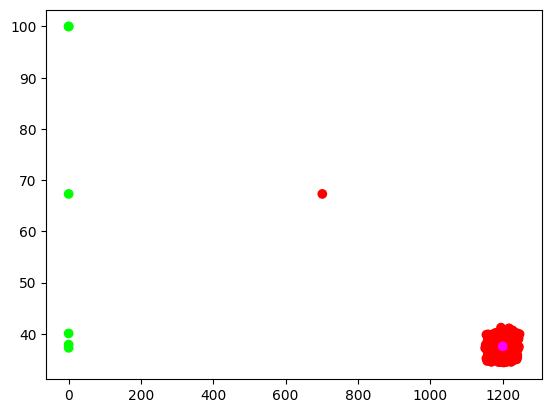

In [48]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [49]:
df = pd.read_csv("./data/Resolute_728H-10_14-10_21.csv")
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/14/2024 12:00:00 am,1467.372900,NaN,NaN
1,10/14/2024 12:02:00 am,1466.604825,NaN,NaN
2,10/14/2024 12:04:00 am,1469.331600,1455.0,NaN
3,10/14/2024 12:06:00 am,1470.335700,NaN,NaN
4,10/14/2024 12:08:00 am,1468.706850,NaN,26.18433


In [50]:
old_setpoint = df.iloc[0, 2]
old_percent_open = 1455

for i in range(0, df.shape[0]):
    current_setpoint = df.iloc[i, 2]
    current_percent_open = df.iloc[i, 3]
    if math.isnan(df.iloc[i, 1]):
        df.iloc[i, 1] = 0.0
    if math.isnan(current_setpoint):
        df.iloc[i, 2] = old_setpoint
    if math.isnan(current_percent_open):
        df.iloc[i, 3] = old_percent_open
    
    old_setpoint = df.iloc[i, 2]
    old_percent_open = df.iloc[i, 3]

In [51]:
dataset = []
X = [] # Current volume
y = [] # Valve open
for i in range(0, df.shape[0]):
    X.append(df.iloc[i, 1])
    y.append(df.iloc[i, 3])
    dataset.append([df.iloc[i, 1], df.iloc[i, 3]])

In [52]:
for d in dataset:
    if math.isnan(d[0]) or math.isnan(d[1]):
        print(d)

In [53]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dataset)

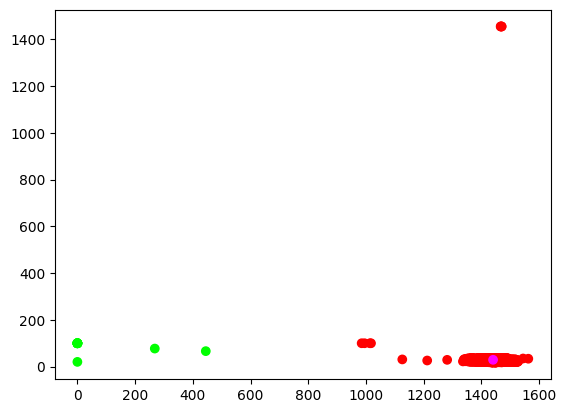

In [54]:
colors = []

for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    if pred == 0:
        colors.append("#FF0000")
    else:
        colors.append("#00FF00")

center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]
X.append(center_x)
y.append(center_y)
colors.append("#FF00FF")


plt.scatter(X, y, c=colors)

In [55]:
center_x = kmeans.cluster_centers_[0][0]
center_y = kmeans.cluster_centers_[0][1]

total = 0
count = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    pred = kmeans.predict([point]).item()
    distance = math.sqrt((point[0] - center_x) ** 2 + (point[1] - center_y) ** 2)
    if pred == 0:
        total += distance
        count += 1
threshold = total / count
threshold *= 2

print(threshold)
error_threshold = 4 * threshold

63.48489000966751


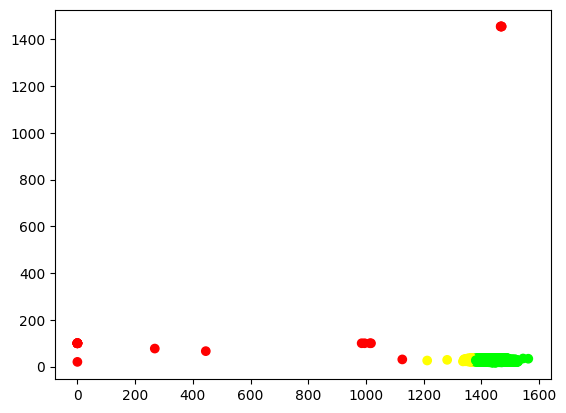

In [56]:
X_concern = []
y_concern = []
colors = []

df["Issue"] = 0
for i in range(0, len(X)):
    point = [X[i].item(), y[i].item()]
    if point[0] < center_x - error_threshold or point[1] > center_y + error_threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FF0000")
        df.iloc[i, 4] = 2.0
    elif point[0] < center_x - threshold or point[1] > center_y + threshold / 5:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#FFFF00")
        df.iloc[i, 4] = 1.0
    else:
        X_concern.append(point[0])
        y_concern.append(point[1])
        colors.append("#00FF00")

plt.scatter(X_concern, y_concern, c=colors)

In [96]:
def kmeans(data, clusters):
    cluster = [data[i] for i in range(0, clusters)]
    for i in range(0, 100):
        totals = [[0.0, 0.0] for i in range(0, clusters)]
        counts = [0 for i in range(0, clusters)]
        for point in data:
            distances = []
            for c in range(0, len(cluster)):
                distances.append(distance(point[0], cluster[c][0], point[1], cluster[c][1]))
            min_i = my_min(distances)
            totals[min_i][0] += point[0]
            totals[min_i][1] += point[1]
            counts[min_i] += 1
        print(counts)
        print(totals)
        for c in range(0, len(cluster)):
            totals[c][0] = totals[c][0] / counts[c]
            totals[c][1] = totals[c][1] / counts[c]
            cluster[c] = totals[c]
    return cluster

def distance(x, x2, y, y2):
    return math.sqrt((x2 - x) ** 2 + (y2 - y) ** 2)

def my_min(distances):
    min_i = 0
    min_value = distances[0]
    for i in range(1, len(distances)):
        if distances[i] < min_value:
            min_value = distances[i]
            min_i = i
    return min_i

In [97]:
kmeans(dataset, 2)

[617, 60]
[[np.float64(217672.47180000003), np.float64(21681.14431000006)], [np.float64(24008.634449999994), np.float64(1765.0834700000003)]]
[360, 317]
[[np.float64(118489.47434999997), np.float64(14187.486600000022)], [np.float64(123191.63189999992), np.float64(9258.74118000001)]]
[177, 500]
[[np.float64(51377.04585000002), np.float64(8599.169939999996)], [np.float64(190304.06039999996), np.float64(14847.057840000041)]]
[49, 628]
[[np.float64(6289.3012499999995), np.float64(4686.31434)], [np.float64(235391.80499999996), np.float64(18759.913440000048)]]
[49, 628]
[[np.float64(6289.3012499999995), np.float64(4686.31434)], [np.float64(235391.80499999996), np.float64(18759.913440000048)]]
[49, 628]
[[np.float64(6289.3012499999995), np.float64(4686.31434)], [np.float64(235391.80499999996), np.float64(18759.913440000048)]]
[49, 628]
[[np.float64(6289.3012499999995), np.float64(4686.31434)], [np.float64(235391.80499999996), np.float64(18759.913440000048)]]
[49, 628]
[[np.float64(6289.301249

[[np.float64(128.35308673469387), np.float64(95.6390681632653)],
 [np.float64(374.8277149681528), np.float64(29.872473630573324)]]

In [98]:
print(center_x)

1440.3941319015062


In [99]:
print(center_y)

29.207610010239108


In [72]:
find_blockage(dataset)

(46.886652842253795,
 187.54661136901518,
 [2.0,
  2.0,
  2.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [73]:
df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open,Issue
0,10/14/2024 12:00:00 am,1467.372900,NaN,1455.00000,2
1,10/14/2024 12:02:00 am,1466.604825,NaN,1455.00000,2
2,10/14/2024 12:04:00 am,1469.331600,1455.0,1455.00000,2
3,10/14/2024 12:06:00 am,1470.335700,1455.0,1455.00000,2
4,10/14/2024 12:08:00 am,1468.706850,1455.0,26.18433,0
